In [169]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})


n = 128
L = 128
dx = L/n
x = np.arange(-L/2,L/2,dx,dtype='complex_')
f = np.cos(x) * np.exp(-np.power(x,2)/25) # Function
df = -(np.sin(x) * np.exp(-np.power(x,2)/25) + (2/25)*x*f) # Derivative

In [170]:
## Approximate derivative using finite difference
dfFD = np.zeros(len(df),dtype='complex_')
for kappa in range(len(df)-1):
    dfFD[kappa] = (f[kappa+1]-f[kappa])/dx
    
dfFD[-1] = dfFD[-2]

In [171]:
Reza=True

In [172]:
## Derivative using FFT (spectral derivative)
fhat = np.fft.fft(f)
if Reza==True:
    #kappa=(2*np.pi/L)*np.fft.fftfreq(n,1/n).astype(int)
    kappa = (2*np.pi/L)*np.asarray(list(range(0, n // 2)) + [0] + list(range(-n // 2 + 1,0)))
else:    
    kappa = (2*np.pi/L)*np.arange(-n/2,n/2)
    kappa = np.fft.fftshift(kappa) # Re-order fft frequencies
dfhat = kappa * fhat * (1j)
dfFFT = np.real(np.fft.ifft(dfhat))


In [173]:
# np.fft.fftshift((2*np.pi/L)*np.arange(-n/2,n/2)),np.fft.fftfreq(n,1/n).astype(int)

In [174]:
#(2*np.pi/L)*np.arange(-n/2,n/2),np.fft.fftshift((2*np.pi/L)*np.arange(-n/2,n/2))

In [175]:
def make_kernel(mode, d):
    if mode == 'sobel':
        hxyz = torch.tensor([1, 2, 1], dtype=torch.float32)
    elif mode == 'scharr':
        hxyz = torch.tensor([3, 10, 3], dtype=torch.float32)
    else:
        raise ValueError('Not valid mode')
    hpxyz = torch.tensor([-1, 0 ,1], dtype=torch.float32)
    if d == 1:
        kernel = torch.zeros((1, 3), dtype=torch.float32)
        for i in range(3):
            kernel[0][i] = hpxyz[i]
        kernel = kernel / kernel.abs().sum(dim=[-1]).view(-1, 1)
    elif d == 2:
        kernel = torch.zeros((2, 3, 3), dtype=torch.float32)
        for i in range(3):
            for j in range(3):
                kernel[0][i][j] = hpxyz[i]*hxyz[j]
                kernel[1][i][j] = hxyz[i]*hpxyz[j]
        kernel = kernel / kernel.abs().sum(dim=[-2,-1]).view(-1, 1, 1)
    elif d == 3:
        kernel = torch.zeros((3, 3, 3, 3), dtype=torch.float32)
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    kernel[0][i][j][k] = hpxyz[i]*hxyz[j]*hxyz[k]
                    kernel[1][i][j][k] = hxyz[i]*hpxyz[j]*hxyz[k]
                    kernel[2][i][j][k] = hxyz[i]*hxyz[j]*hpxyz[k]
        kernel = kernel / kernel.abs().sum(dim=[-3,-2,-1]).view(-1, 1, 1, 1)
    kernel = kernel.flip(0)
    return kernel

In [176]:
mode = 'sobel'
d = 1
c = 1
kernel = make_kernel(mode, d)
print(kernel)
kernel = kernel.unsqueeze(0).repeat(c,1,1)
input = torch.tensor(np.float32(f)).view(1,c,-1)
print(input.size())
print(kernel.size())
spatial_pad = [kernel.size(2) // 2,
               kernel.size(2) // 2]
padded_input = F.pad(input, spatial_pad, 'replicate')
dfSobel = F.conv1d(padded_input, kernel, stride=1, padding=0, groups=c).squeeze().numpy() / dx

tensor([[-0.5000,  0.0000,  0.5000]])
torch.Size([1, 1, 128])
torch.Size([1, 1, 3])


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


D:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


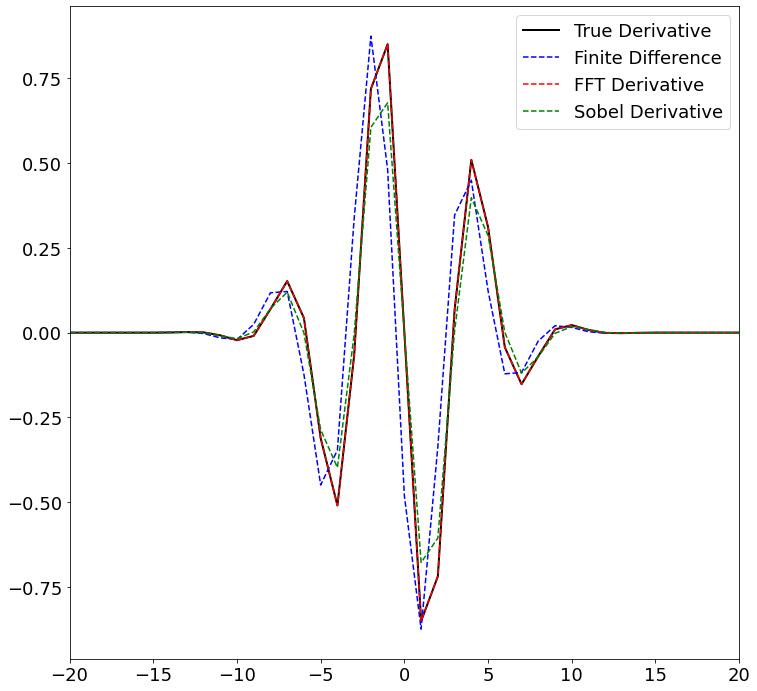

In [177]:
## Plots
plt.plot(x,df.real,color='k',LineWidth=2,label='True Derivative')
plt.plot(x,dfFD.real,'--',color='b',LineWidth=1.5,label='Finite Difference')
plt.plot(x,dfFFT.real,'--',color='r',LineWidth=1.5,label='FFT Derivative')
plt.plot(x,dfSobel,'--',color='g',LineWidth=1.5,label='Sobel Derivative')
plt.legend()
plt.xlim([-20,20])
plt.show()

In [178]:
# L1 error

In [181]:
FD_error = np.abs(df.real - dfFD.real).mean()
FFT_error = np.abs(df.real - dfFFT.real).mean()
Sobel_error = np.abs(df.real - dfSobel).mean()
print('Finite Difference: {}'.format(FD_error))
print('FFT Derivative error: {}'.format(FFT_error))
print('Sobel Derivative error: {}'.format(Sobel_error))

Finite Difference: 0.024359661030593872
FFT Derivative error: 2.662576961786048e-14
Sobel Derivative error: 0.009097433905904066
